In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist, cdist

In [2]:
#DLEDMD
import tensorflow as tf
import DLEDMD_eig

C:\Users\chong\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\chong\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\chong\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\chong\AppData\Local\Conti

In [3]:
#MSE and NSE
def MSE(x,y):
    return np.sqrt(np.mean(np.square(x-y)))

def NSE(pre,tar):
    a=np.sum(np.square(pre-tar))/np.sum(np.square(tar-np.mean(tar)))
    return 1-a

In [4]:
def Pre_data():
    #Prepare training data (set0)
    df_s0 = pd.read_excel(r'./save_data/excelfile/rain0_set0_state_data.xlsx')
    df_a0= pd.read_excel(r'./save_data/excelfile/rain0_set0_action_data.xlsx')
    df_r0= pd.read_excel(r'./save_data/excelfile/rain0_set0_rain_data.xlsx')
    dt_s0=df_s0.values[:1,1:]
    dt_a0=df_a0.values[:1,1:]
    dt_r0=df_r0.values[:1,1:]
    
    data=np.concatenate((dt_s0,dt_a0,dt_r0),axis=1)
    for it in [0,2,4,6,8,9]:
        for jt in [0,1,2]:   
            df_s0 = pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_state_data.xlsx')
            df_a0= pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_action_data.xlsx')
            df_r0= pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_rain_data.xlsx')
            dt_s0=df_s0.values[:,1:]
            dt_a0=df_a0.values[:,1:]
            dt_r0=df_r0.values[:,1:]
            tem=np.concatenate((dt_s0,dt_a0,dt_r0),axis=1)
            data=np.concatenate((data,tem),axis=0)
    
    data=data[1:,:]
            
    #Prepare test1 data
    df_s0 = pd.read_excel(r'./save_data/excelfile/rain0_set1_state_data.xlsx')
    df_a0= pd.read_excel(r'./save_data/excelfile/rain0_set1_action_data.xlsx')
    df_r0= pd.read_excel(r'./save_data/excelfile/rain0_set1_rain_data.xlsx')
    dt_s0=df_s0.values[:,1:]
    dt_a0=df_a0.values[:,1:]
    dt_r0=df_r0.values[:,1:]
    data_test1=[]
    data_test1.append(np.concatenate((dt_s0,dt_a0,dt_r0),axis=1))
    for it in [3,5,7]:
        for jt in [1]:   
            df_s0 = pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_state_data.xlsx')
            df_a0= pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_action_data.xlsx')
            df_r0= pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_rain_data.xlsx')
            dt_s0=df_s0.values[:,1:]
            dt_a0=df_a0.values[:,1:]
            dt_r0=df_r0.values[:,1:]
            tem=np.concatenate((dt_s0,dt_a0,dt_r0),axis=1)
            data_test1.append(tem)
    
    #Prepare training data2 (set0)
    df_s0 = pd.read_excel(r'./save_data/excelfile/rain0_set0_state_data.xlsx')
    df_a0= pd.read_excel(r'./save_data/excelfile/rain0_set0_action_data.xlsx')
    df_r0= pd.read_excel(r'./save_data/excelfile/rain0_set0_rain_data.xlsx')
    dt_s0=df_s0.values[:,1:]
    dt_a0=df_a0.values[:,1:]
    dt_r0=df_r0.values[:,1:]
    
    return data,data_test1

data,data_test1=Pre_data()
print(data.shape)

(1080, 13)


# DLEDMD

In [5]:
X_train=data[:data.shape[0]-2,:4]
X_train_F=data[:data.shape[0]-2,4:]
Y_train=data[1:data.shape[0]-1,:4]

g2=tf.Graph()
with g2.as_default():
    params={}
    params['enlayers']=[[4+9,10],[10,50],[50,100],[100,100]]
    params['K']=[100,100]
    params['delayers']=[[100,100],[100,50],[50,10],[10,4]]

    params['input_layer']=4#X_train.shape[1]
    params['f_layer']=9#X_train_F.shape[1]
    params['output_layer']=4#Y_train.shape[1]
    params['lr']=0.0001


    model=DLEDMD_eig.DLEDMD(params,X_train,Y_train,X_train_F)
    ybar=model.forward_net(model.x,model.f)
    loss=model.Loss(model.x,model.f,model.y)
    op=model.opt(loss)
    sess=tf.compat.v1.Session()
    
    #init_op = tf.compat.v1.global_variables_initializer()
    #sess.run(init_op)
    
    saver = tf.compat.v1.train.Saver()
    
    saver.restore(sess,'./emulator_model/DLEDMD_emulator_model/DLEDMD_model.ckpt')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./emulator_model/DLEDMD_emulator_model/DLEDMD_model.ckpt


In [6]:
K=sess.run(model.weights['K'])

In [24]:
u,s,v=np.linalg.svd(K)

In [8]:
S,U=np.linalg.eig(K)

In [9]:
eig_data=[]
for ei in S:
    eig_data.append([np.real(ei),np.imag(ei)])

In [10]:
eig_data=np.array(eig_data)

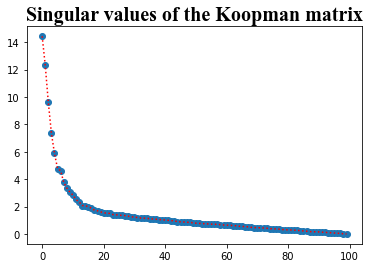

In [21]:
font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 20,}

plt.scatter([i for i in range(s.shape[0])],s)
plt.plot(s,'r:')
plt.title('Singular values of the Koopman matrix',font1)
plt.savefig('6.3-singular.png', bbox_inches='tight', dpi=500)   

# Draw Matrix

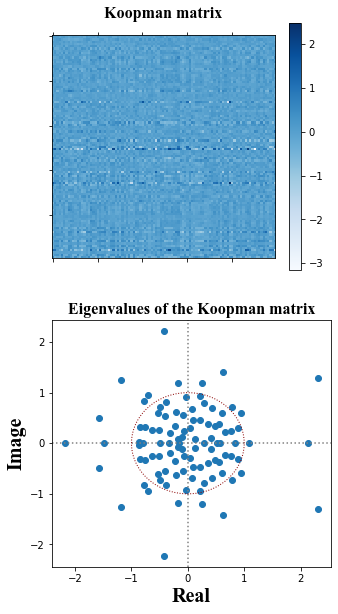

In [12]:
font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 20,}

font2 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 16,}

fig = plt.figure(figsize=(5,10))
it=0

axes=fig.add_subplot(2,1,1)
ax=axes.matshow(K,cmap=plt.cm.Blues)
axes.set_xticklabels([])
axes.set_yticklabels([])
plt.colorbar(ax)
axes.set_title('Koopman matrix',font2)

axes=fig.add_subplot(2,1,2)
axes.scatter(eig_data[:,0],eig_data[:,1])
axes.axhline(y=0,ls=":",c="grey")#添加水平直线
axes.axvline(x=0,ls=":",c="grey")#添加水平直线
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)
y = np.sin(theta)
axes.plot(x, y, color="darkred", linewidth=1,linestyle=':')
plt.xlabel('Real',font1)
plt.ylabel('Image',font1)
axes.set_title('Eigenvalues of the Koopman matrix',font2)


plt.savefig('6.3-eigenvalues.png', bbox_inches='tight', dpi=500)   

# Draw singular fig

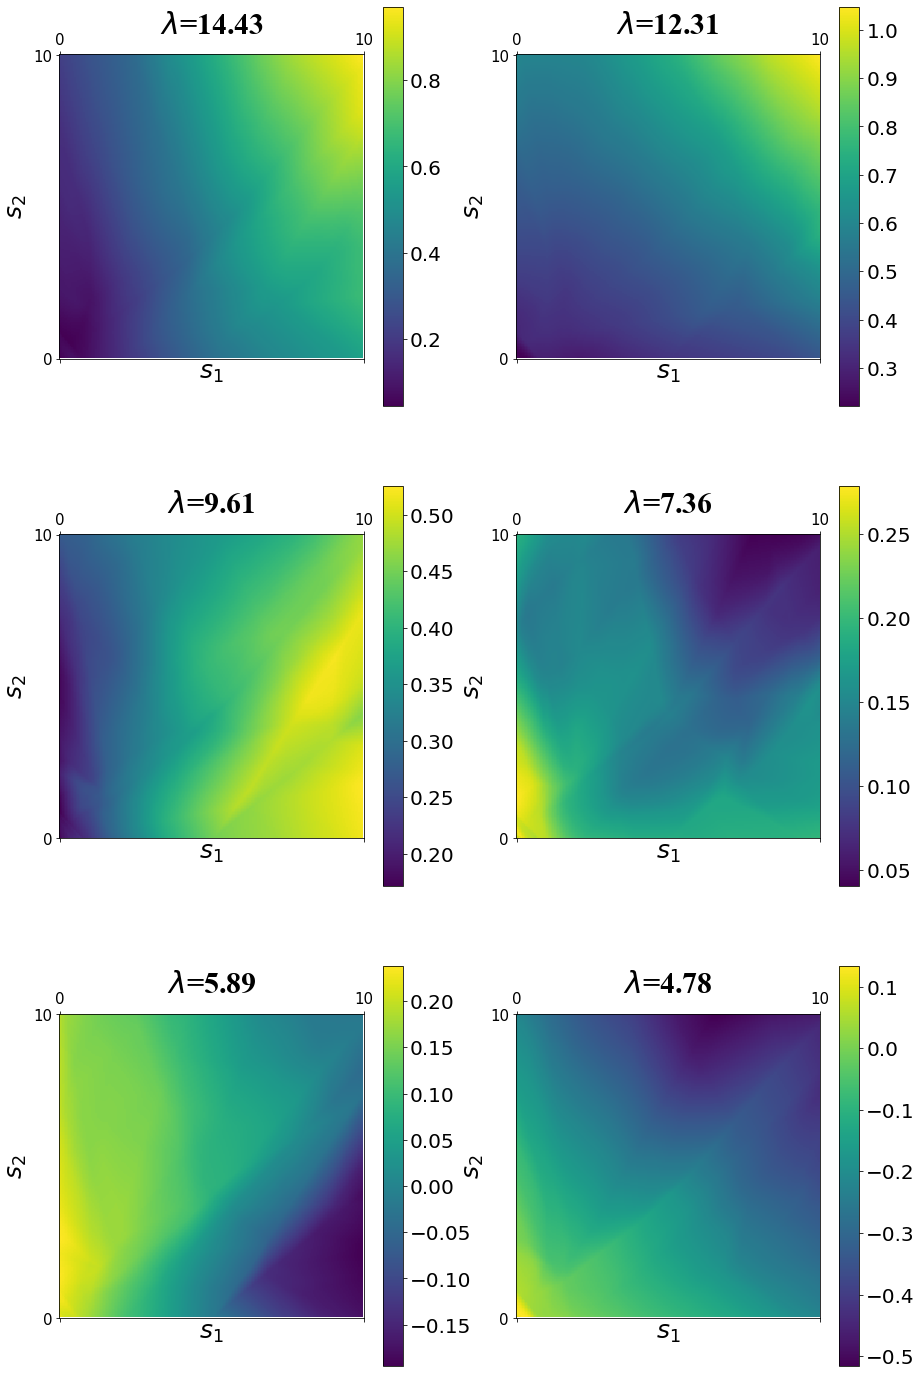

In [26]:
k=0

font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 30,}

font2 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 25,}


fig = plt.figure(figsize=(15,25))
it=0


for j in range(3):
    for i in range(2):
        axes=fig.add_subplot(3,2,it+1)
        it=it+1
        results=[]
        for ix in np.arange(0,10,0.05):
            line_R=[]
            for jx in np.arange(0,10,0.05):
                xt=[[ix,jx,0,0]]
                tem=[[0 for it in range(9)]]
                #x=np.array(xt+tem)
                #line.append(x.dot(u[1,:]))
                faix=sess.run(model.faix,feed_dict={model.x:xt,model.f:tem})
                line_R.append(v[:,it-1].dot(faix.T)[0])
            results.append(line_R)
        results=np.array(results)
        rt=np.zeros(results.shape)
        L=results.shape[0]-1
        for line in np.arange(rt.shape[0]):
            rt[line,:]=results[L-line,:]
        ax=axes.matshow(rt)
        plt.xticks([0,200],['0','10'],fontsize=15)
        plt.yticks([0,200],['10','0'],fontsize=15)
        plt.xlabel('$s_{1}$',fontdict=font2)
        plt.ylabel('$s_{2}$',fontdict=font2)
        plt.title('$\lambda$='+"%.2f"% s[it-1],fontdict=font1)
        cb=plt.colorbar(ax)
        cb.ax.tick_params(labelsize=20)  #设置色标刻度字体大小。
    k=k+1
    
fig.savefig('6.3-sig_fun.png', bbox_inches='tight', dpi=500)  

# Draw eigenfunction fig

In [14]:
Uinv=np.linalg.inv(U)

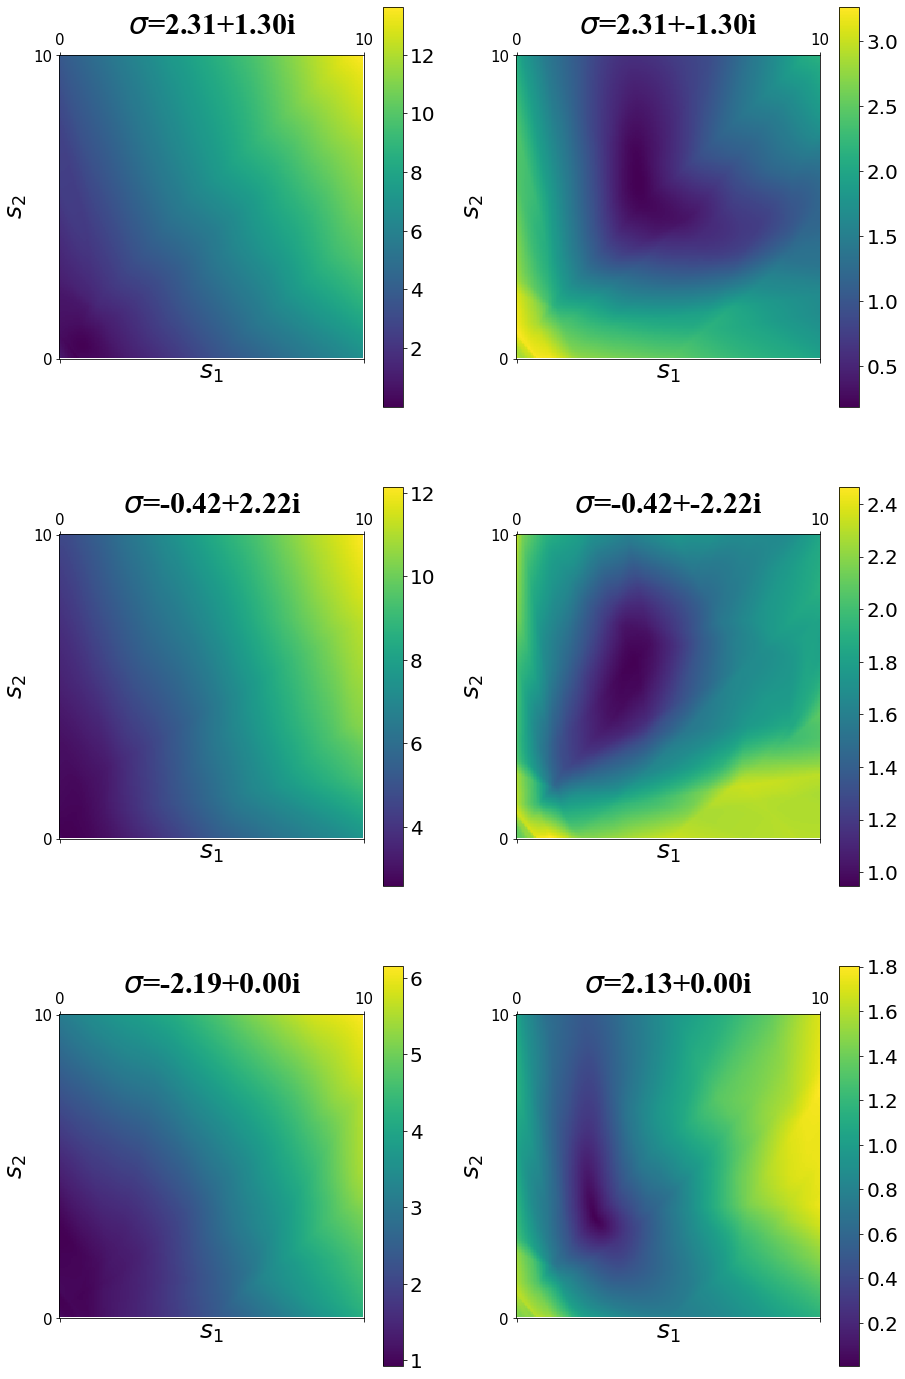

In [22]:
k=0

font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 30,}

font2 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 25,}

#EIGF=Uinv.dot()

fig = plt.figure(figsize=(15,25))
it=0
for j in range(3):
    for i in range(2):
        axes=fig.add_subplot(3,2,it+1)
        it=it+1
        results=[]
        for ix in np.arange(0,10,0.05):
            line_R=[]
            for jx in np.arange(0,10,0.05):
                xt=[[ix,jx,0,0]]
                tem=[[0 for it in range(9)]]
                #x=np.array(xt+tem)
                #line.append(x.dot(u[1,:]))
                faix=sess.run(model.faix,feed_dict={model.x:xt,model.f:tem})
                #line_R.append(np.abs(faix.dot(U[:,it])[0]))
                line_R.append(np.abs(Uinv[:,it].dot(faix.T)[0]))
            results.append(line_R)
        results=np.array(results)
        rt=np.zeros(results.shape)
        L=results.shape[0]-1
        for line in np.arange(rt.shape[0]):
            rt[line,:]=results[L-line,:]
        ax=axes.matshow(rt)
        plt.xticks([0,200],['0','10'],fontsize=15)
        plt.yticks([0,200],['10','0'],fontsize=15)
        plt.xlabel('$s_{1}$',fontdict=font2)
        plt.ylabel('$s_{2}$',fontdict=font2)
        plt.title('$\sigma$='+"%.2f"% eig_data[it-1][0]+'+'+"%.2f"% eig_data[it-1][1]+'i',fontdict=font1)
        #plt.colorbar(ax)
        cb=plt.colorbar(ax)
        cb.ax.tick_params(labelsize=20)  #设置色标刻度字体大小。
        
    k=k+1
    
fig.savefig('6.3-eig_fun.png', bbox_inches='tight', dpi=500)  

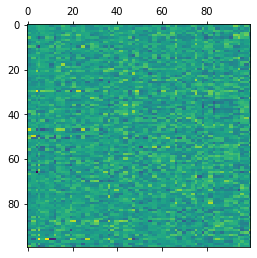

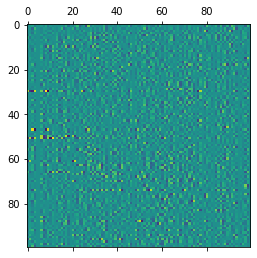

In [16]:
plt.matshow(U.real)
plt.matshow(U.imag)